<a href="https://colab.research.google.com/github/zhisheng-hua/Reproducing-and-Extending-the-CycleGAN-Model/blob/main/CycleGAN_reproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import itertools
import os
import random
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset
from torchvision.utils import save_image
from torchvision import transforms
from tqdm import tqdm

In [ ]:
%matplotlib inline

# Hyperparameters and Constant Variables

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cuda


In [ ]:
DATASET_DIR = "/content/drive/MyDrive/ECE-GY 6953 DL/Project/Datasets/cheetah2hyena/"
TRAIN_A_PATH = DATASET_DIR + "train/cheetah"
TRAIN_B_PATH = DATASET_DIR + "train/hyena"
TEST_A_PATH = DATASET_DIR + "validation/cheetah"
TEST_B_PATH = DATASET_DIR + "validation/hyena"

MODEL_DIR = "/content/drive/MyDrive/ECE-GY 6953 DL/Project/SavedModels/"

VISUAL_DIR = "/content/drive/MyDrive/ECE-GY 6953 DL/Project/Visualizations/"

In [ ]:
BATCH_SIZE = 1
NUM_EPOCHS = 200
NUM_EPOCHS_DECAY = 100 # the number of last epoches during which lr decays to 0
MAX_NUM_SAMPLES = 1000 # if larger than the number of training/testing samples, use all samples

LR = 0.0002
LAMBDA_CYCLE = 10.0
LAMBDA_IDT = 0 # change based on different tasks
IMAGE_POOL_SIZE = 50

NUM_DATALOADER_WORKERS = 2
SAVE_MODELS = True
SAVE_LOSS_PLOTS = True

# Helper Functions

In [ ]:
# The code in this cell is adapted from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git.

# Method to obtain/insert images from/into the image pool
def query_image_pool(image_pool, pool_size, curr_images):
  if pool_size == 0:
      return curr_images
  ret_images = []
  for image in curr_images:
      image = torch.unsqueeze(image.data, 0)
      if len(image_pool) < pool_size: # if buffer is not full
          image_pool.append(image)
          ret_images.append(image)
      else: # if buffer is full
          # by 50% chance, return an old image from the pool and replace it with
          # a current image; otherwise, return the current image
          p = random.uniform(0, 1)
          if p > 0.5:
              random_id = random.randint(0, pool_size - 1)
              old_image = image_pool[random_id].clone()
              image_pool[random_id] = image
              ret_images.append(old_image)
          else:
              ret_images.append(image)
  return torch.cat(ret_images, 0)

In [ ]:
# The code in this cell is adapted from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git.

# Method to initialize weights of the given model
def init_weights(model):
  def init_func(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
      init.normal_(m.weight.data, 0.0, 0.02)
      if hasattr(m, 'bias') and m.bias is not None:
          init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:
      init.normal_(m.weight.data, 1.0, 0.02)
      init.constant_(m.bias.data, 0.0)
  model.apply(init_func)

In [ ]:
# The code in this cell is adapted from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git.

# Method to post-processing the output image of the generator
def post_processing_image(image):
  image = image.cpu().float().numpy()
  image_np = (np.transpose(image, (1, 2, 0)) + 1) / 2.0 * 255.0
  return image_np.astype(np.uint8)

# Data Preparation

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, A_dir, B_dir, transform, random_pairs=True):
        self.A_dir = A_dir
        self.B_dir = B_dir
        self.transform = transform
        self.random_pairs = random_pairs

        self.A_img_filenames = os.listdir(self.A_dir)[:MAX_NUM_SAMPLES]
        self.B_img_filenames = os.listdir(self.B_dir)[:MAX_NUM_SAMPLES]
        self.A_size = len(self.A_img_filenames)
        self.B_size = len(self.B_img_filenames)

    def __len__(self):
        return max(self.A_size, self.B_size)

    def __getitem__(self, index):
        A_img_path = os.path.join(self.A_dir,
                                  self.A_img_filenames[index % self.A_size])
        if self.random_pairs:
          B_index = random.randint(0, self.B_size - 1)
        else:
          B_index = index % self.B_size
        B_img_path = os.path.join(self.B_dir, self.B_img_filenames[B_index])

        A_img = self.transform(Image.open(A_img_path).convert("RGB"))
        B_img = self.transform(Image.open(B_img_path).convert("RGB"))

        return A_img, B_img

In [ ]:
# Define image transformation
train_data_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

test_data_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [ ]:
# Setup datasets and dataloaders
train_dataset = CustomDataset(TRAIN_A_PATH, TRAIN_B_PATH, train_data_transform,
                              random_pairs=True)
test_dataset = CustomDataset(TEST_A_PATH, TEST_B_PATH, test_data_transform,
                             random_pairs=False)
print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(train_dataset))

train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=NUM_DATALOADER_WORKERS)
test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=NUM_DATALOADER_WORKERS)

Number of training samples: 900
Number of testing samples: 900


# Model Architecture

## Generator

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channel, out_channel, kernel_size, stride, padding, use_leaky=False, use_norm=True, use_acv=True):
    super().__init__()
    self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
    if use_norm:
      self.norm = nn.InstanceNorm2d(out_channel)
    else:
      self.norm = nn.Identity()
    if not use_acv:
      self.acv = nn.Identity()
    elif use_leaky:
      self.acv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
      self.acv = nn.ReLU(inplace=True)
  def forward(self, x):
    x = self.conv(x)
    x = self.norm(x)
    return self.acv(x)

In [ ]:
class UpsamlingBlock(nn.Module):
  def __init__(self, in_channel, out_channel, use_dropout=False, p=0.5):
    super().__init__()
    self.use_dropout = use_dropout
    self.conv = nn.ConvTranspose2d(in_channel, out_channel, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.norm = nn.InstanceNorm2d(out_channel)
    self.dropout = nn.Dropout(p)
    self.acv = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.conv(x)
    x = self.norm(x)
    if self.use_dropout:
      x = self.dropout(x)
    return self.acv(x)

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, channel, p=0.5):
    super().__init__()
    self.padding = nn.ReflectionPad2d(1)
    self.conv1 = ConvBlock(channel, channel, kernel_size=3, stride=1, padding=0, use_norm=True)
    self.conv2 = ConvBlock(channel, channel, kernel_size=3, stride=1, padding=0, use_norm=True, use_acv=False)

  def forward(self, x):
    x1 = self.padding(x)
    x1 = self.conv1(x1)
    x1 = self.padding(x1)
    x1 = self.conv2(x1)
    return x + x1

In [ ]:
class Generator(nn.Module):
  def __init__(self, in_channel, out_channel, res_block_num=9):
    super().__init__()
    layers = []
    reflect_pad = nn.ReflectionPad2d(3)
    layers += [reflect_pad, 
          ConvBlock(in_channel, 64, kernel_size=7, stride=1, padding=0, use_leaky=False, use_norm=True, use_acv=True),
          ConvBlock(64, 128, kernel_size=3, stride=2, padding=1, use_leaky=False, use_norm=True, use_acv=True),
          ConvBlock(128, 256, kernel_size=3, stride=2, padding=1, use_leaky=False, use_norm=True, use_acv=True),
          ]
    for i in range(res_block_num):
      layers += [ResBlock(256)]
    
    layers += [UpsamlingBlock(256, 128, use_dropout=False),
          UpsamlingBlock(128, 64, use_dropout=False)
          ]
    layers += [reflect_pad,
          nn.Conv2d(64, out_channel, kernel_size=7, padding=0),
          nn.Tanh(),
          ]
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)
    


## Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_channel):
    super().__init__()
    self.conv1 = ConvBlock(in_channel, 64, kernel_size=4, stride=2, padding=1, use_leaky=True, use_norm=False, use_acv=True)
    self.conv2 = ConvBlock(64, 128, kernel_size=4, stride=2, padding=1, use_leaky=True, use_norm=True, use_acv=True)
    self.conv3 = ConvBlock(128, 256, kernel_size=4, stride=2, padding=1, use_leaky=True, use_norm=True, use_acv=True)
    self.conv4 = ConvBlock(256, 512, kernel_size=4, stride=2, padding=1, use_leaky=True, use_norm=True, use_acv=True)
    self.output = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    return self.output(x)

   

## CycleGAN

In [ ]:
# Method to train CycleGAN for one epoch
# Combine generators and discriminators together
# Calculate losses and backpropagation
def train_CycleGAN_for_one_epoch(G_A, D_B, G_B, D_A,
                                 cri_GAN, cri_Cycle, cri_Idt,
                                 opt_G, opt_D,
                                 data_loader,
                                 use_image_pools=False, image_pools=None):
  model_name = "CycleGAN_" + os.path.basename(DATASET_DIR[:-1])

  avg_loss_G = 0
  avg_loss_D_B = 0 # Discriminator for A->B
  avg_loss_D_A = 0 # Discriminator for B->A

  G_A.train()
  D_B.train()
  G_B.train()
  D_A.train()

  # labels for discriminators
  D_labels_real = None
  D_labels_fake = None

  for i, (A_real, B_real) in enumerate(tqdm(data_loader)):
    A_real = A_real.to(DEVICE)
    B_real = B_real.to(DEVICE)

    # forward pass; generate fake images
    B_fake = G_A(A_real) # G_A(A)
    A_fake = G_B(B_real) # G_B(B)

    # if use old generated images to train discriminators
    if use_image_pools:
      B_fake_for_D = query_image_pool(image_pools['B'], IMAGE_POOL_SIZE,
                                      B_fake.detach())
      A_fake_for_D = query_image_pool(image_pools['A'], IMAGE_POOL_SIZE,
                                      A_fake.detach())
      if i == 0:
        model_name += "_ImagePool"
    else:
      B_fake_for_D = B_fake.detach()
      A_fake_for_D = A_fake.detach()
      if i == 0:
        model_name += "_NoImagePool"

    ### Update discriminators
    opt_D.zero_grad()
    ## Update D_B (discriminator for A->B)
    # Real images
    D_B_real_output = D_B(B_real)
    if i == 0: # initialize Ds' labels; only do once
      D_labels_real = torch.ones(D_B_real_output.shape).to(DEVICE)
      D_labels_fake = torch.zeros(D_B_real_output.shape).to(DEVICE)
    loss_D_B_real = cri_GAN(D_B_real_output, D_labels_real)
    # Fake images
    loss_D_B_fake = cri_GAN(D_B(B_fake_for_D), D_labels_fake)
    # Combine losses and compute gradients
    loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
    loss_D_B.backward()
    ## Update D_A (discriminator for B->A)
    # Real images
    loss_D_A_real = cri_GAN(D_A(A_real), D_labels_real)
    # Fake images
    loss_D_A_fake = cri_GAN(D_A(A_fake_for_D), D_labels_fake)
    # Combine losses and compute gradients
    loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
    loss_D_A.backward()
    # Update the optimizer
    opt_D.step()

    ### Update generators
    opt_G.zero_grad()
    # GAN losses
    loss_GAN_G_A = cri_GAN(D_B(B_fake), D_labels_real)
    loss_GAN_G_B = cri_GAN(D_A(A_fake), D_labels_real)
    # Cycle losses
    loss_Cycle_G_A = cri_Cycle(G_B(B_fake), A_real) # loss(G_B(G_A(A)), A)
    loss_Cycle_G_B = cri_Cycle(G_A(A_fake), B_real) # loss(G_A(G_B(B)), B)
    # Identity losses
    loss_Idt_G_A = cri_Idt(G_A(B_real), B_real) # loss(G_A(B), B)
    loss_Idt_G_B = cri_Idt(G_B(A_real), A_real) # loss(G_B(A), A)
    # Combine all losses
    loss_G = (loss_GAN_G_A + loss_GAN_G_B
              + LAMBDA_CYCLE * (loss_Cycle_G_A + loss_Cycle_G_B
                                + LAMBDA_IDT * (loss_Idt_G_A + loss_Idt_G_B)))
    # Update
    loss_G.backward()
    opt_G.step()

    avg_loss_G += loss_G.item()
    avg_loss_D_B += loss_D_B.item()
    avg_loss_D_A += loss_D_A.item()

  avg_loss_G = avg_loss_G / len(data_loader)
  avg_loss_D_B = avg_loss_D_B / len(data_loader)
  avg_loss_D_A = avg_loss_D_A / len(data_loader)

  return model_name, (avg_loss_G, avg_loss_D_B, avg_loss_D_A)

# Training

In [ ]:
# Training setup

# Generator and Discriminator models
# Mapping A->B
G_A = Generator(in_channel=3, out_channel=3).to(DEVICE)
D_B = Discriminator(in_channel=3).to(DEVICE)
# # Mapping B->A
G_B = Generator(in_channel=3, out_channel=3).to(DEVICE)
D_A = Discriminator(in_channel=3).to(DEVICE)

# Initialize the weights of models
init_weights(G_A)
init_weights(D_B)
init_weights(G_B)
init_weights(D_A)

# Losses
cri_GAN = nn.MSELoss() # Least-Squares GAN; see Reference 35 of the paper
cri_Cycle = nn.L1Loss()
cri_Idt = nn.L1Loss()

# Optimizers
opt_G = torch.optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()),
                         lr=LR, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(itertools.chain(D_B.parameters(), D_A.parameters()),
                         lr=LR, betas=(0.5, 0.999))

# Image pools
image_pools = {'A': [], 'B': []}

# Schedulers for learning rate decay
def lambda_rule(epoch): # adapted from authors' Github repo 
  lr_l = 1.0 - max(0, epoch - (NUM_EPOCHS - NUM_EPOCHS_DECAY)) / float(NUM_EPOCHS_DECAY + 1)
  return lr_l
sclr_G = lr_scheduler.LambdaLR(opt_G, lr_lambda=lambda_rule)
sclr_D = lr_scheduler.LambdaLR(opt_D, lr_lambda=lambda_rule)

# Records for losses
losses_G = []
losses_D_B = []
losses_D_A = []

In [ ]:
# ONLY use this cell to load saved checkpoints to continue training
# Remember to change EPOCHS and LR!!!
# model_GA_path = MODEL_DIR + "CycleGAN_cheetah2hyena_ImagePool_GA_180.pt"
# model_DB_path = MODEL_DIR + "CycleGAN_cheetah2hyena_ImagePool_DB_180.pt"
# model_GB_path = MODEL_DIR + "CycleGAN_cheetah2hyena_ImagePool_GB_180.pt"
# model_DA_path = MODEL_DIR + "CycleGAN_cheetah2hyena_ImagePool_DA_180.pt"
# optG_path = MODEL_DIR + "CycleGAN_cheetah2hyena_ImagePool_optG_180.pt"
# optD_path = MODEL_DIR + "CycleGAN_cheetah2hyena_ImagePool_optD_180.pt"
# losses_path = MODEL_DIR + "CycleGAN_cheetah2hyena_ImagePool_losses_180.pt"

# G_A = Generator(in_channel=3, out_channel=3)
# D_B = Discriminator(in_channel=3)
# G_B = Generator(in_channel=3, out_channel=3)
# D_A = Discriminator(in_channel=3)

# G_A.load_state_dict(torch.load(model_GA_path))
# D_B.load_state_dict(torch.load(model_DB_path))
# G_B.load_state_dict(torch.load(model_GB_path))
# D_A.load_state_dict(torch.load(model_DA_path))
# G_A = G_A.to(DEVICE)
# D_B = D_B.to(DEVICE)
# G_B = G_B.to(DEVICE)
# D_A = D_A.to(DEVICE)

# opt_G = torch.optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()),
#                          lr=0.000004, betas=(0.5, 0.999))
# opt_D = torch.optim.Adam(itertools.chain(D_B.parameters(), D_A.parameters()),
#                          lr=0.000004, betas=(0.5, 0.999))
# opt_G.load_state_dict(torch.load(optG_path))
# opt_D.load_state_dict(torch.load(optD_path))
# sclr_G = lr_scheduler.LambdaLR(opt_G, lr_lambda=lambda_rule, last_epoch=197)
# sclr_D = lr_scheduler.LambdaLR(opt_D, lr_lambda=lambda_rule, last_epoch=197)

# saved_losses = torch.load(losses_path)
# losses_G.extend(saved_losses[0])
# losses_D_B.extend(saved_losses[1])
# losses_D_A.extend(saved_losses[2])

In [ ]:
# Train for all epoches
# for epoch in range(1, NUM_EPOCHS+1):
for epoch in range(198, 201):
  print("Epoch: {} / {}".format(epoch, NUM_EPOCHS))

  # Training process
  model_name, stats = train_CycleGAN_for_one_epoch(G_A, D_B, G_B, D_A,
                                                   cri_GAN, cri_Cycle, cri_Idt,
                                                   opt_G, opt_D,
                                                   train_data_loader,
                                                   use_image_pools=True,
                                                   image_pools=image_pools)
  sclr_G.step()
  sclr_D.step()

  losses_G.append(stats[0])
  losses_D_B.append(stats[1])
  losses_D_A.append(stats[2])

  if epoch % 20 == 0:
    if SAVE_MODELS:
      torch.save(G_A.state_dict(), MODEL_DIR + model_name + "_GA_" + str(epoch)+ ".pt")
      torch.save(D_B.state_dict(), MODEL_DIR + model_name + "_DB_" + str(epoch)+ ".pt")
      torch.save(G_B.state_dict(), MODEL_DIR + model_name + "_GB_" + str(epoch)+ ".pt")
      torch.save(D_A.state_dict(), MODEL_DIR + model_name + "_DA_" + str(epoch)+ ".pt")
      torch.save(opt_G.state_dict(), MODEL_DIR + model_name + "_optG_" + str(epoch)+ ".pt")
      torch.save(opt_D.state_dict(), MODEL_DIR + model_name + "_optD_" + str(epoch)+ ".pt")
      torch.save([losses_G, losses_D_B, losses_D_A], MODEL_DIR + model_name + "_losses_" + str(epoch)+ ".pt")

  if epoch == NUM_EPOCHS:
    print()
  print("----------------------------------------------------------------------------------")
  print("  Loss G: %f, Loss D_B: %f, Loss D_A: %f, Next LR: %f" % (
      stats[0], stats[1], stats[2], sclr_G.get_last_lr()[0]
  ))
  print("----------------------------------------------------------------------------------")

Epoch: 198 / 200


100%|██████████| 900/900 [02:43<00:00,  5.49it/s]


----------------------------------------------------------------------------------
  Loss G: 2.901759, Loss D_B: 0.093851, Loss D_A: 0.085556, Next LR: 0.000004
----------------------------------------------------------------------------------
Epoch: 199 / 200


100%|██████████| 900/900 [02:42<00:00,  5.53it/s]


----------------------------------------------------------------------------------
  Loss G: 2.893423, Loss D_B: 0.094604, Loss D_A: 0.084592, Next LR: 0.000002
----------------------------------------------------------------------------------
Epoch: 200 / 200


100%|██████████| 900/900 [02:42<00:00,  5.53it/s]



----------------------------------------------------------------------------------
  Loss G: 2.876514, Loss D_B: 0.095711, Loss D_A: 0.085088, Next LR: 0.000000
----------------------------------------------------------------------------------


In [ ]:
# Save the trained models; ONLY final models
if SAVE_MODELS:
  torch.save(G_A.state_dict(), MODEL_DIR + model_name + "_GA.pt")
  torch.save(D_B.state_dict(), MODEL_DIR + model_name + "_DB.pt")
  torch.save(G_B.state_dict(), MODEL_DIR + model_name + "_GB.pt")
  torch.save(D_A.state_dict(), MODEL_DIR + model_name + "_DA.pt")

# Evalutaion

## Loss Curves

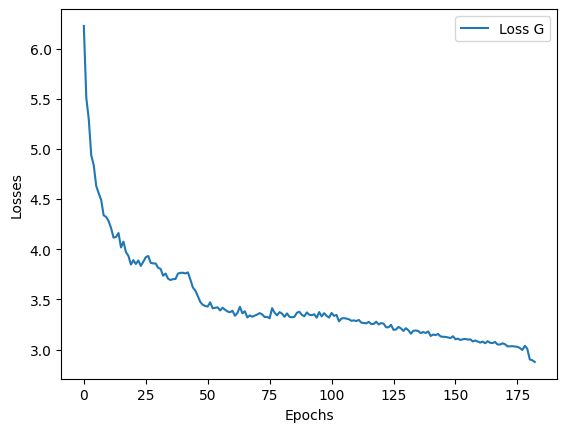

In [ ]:
# Plot Loss G
plt.figure()
plt.plot(losses_G, label="Loss G")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()

if SAVE_LOSS_PLOTS:
  plt.savefig(VISUAL_DIR + model_name + "_losses_G.png")

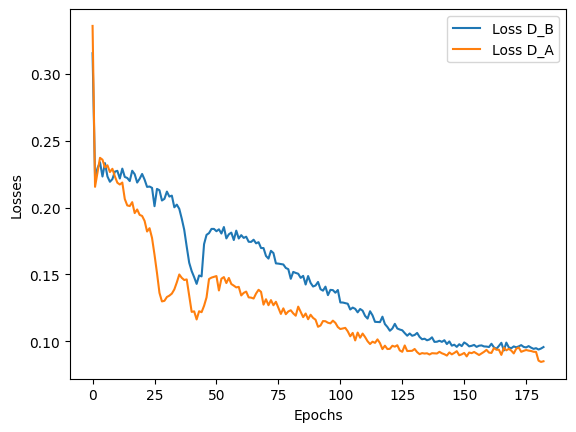

In [ ]:
# Plot Loss D_B and Loss D_A
plt.figure()
plt.plot(losses_D_B, label="Loss D_B")
plt.plot(losses_D_A, label="Loss D_A")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()

if SAVE_LOSS_PLOTS:
  plt.savefig(VISUAL_DIR + model_name + "_losses_D.png")

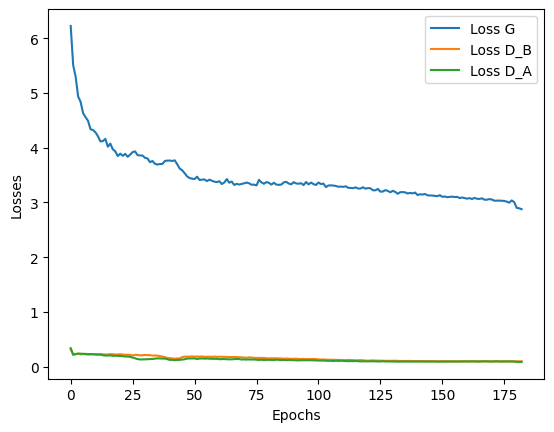

In [ ]:
# Plot all losses
plt.figure()
plt.plot(losses_G, label="Loss G")
plt.plot(losses_D_B, label="Loss D_B")
plt.plot(losses_D_A, label="Loss D_A")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()

if SAVE_LOSS_PLOTS:
  plt.savefig(VISUAL_DIR + model_name + "_losses_GandD.png")

## Test Sample Visualization

In [ ]:
# Use this block when loading from saved models
# model_A_path = MODEL_DIR + "CycleGAN_cheetah2hyena_ImagePool_GA.pt"
# model_B_path = MODEL_DIR + "CycleGAN_cheetah2hyena_ImagePool_GB.pt"
# G_A = Generator(in_channel=3, out_channel=3).to(DEVICE)
# G_B = Generator(in_channel=3, out_channel=3).to(DEVICE)
# G_A.load_state_dict(torch.load(model_A_path))
# G_B.load_state_dict(torch.load(model_B_path))

<All keys matched successfully>

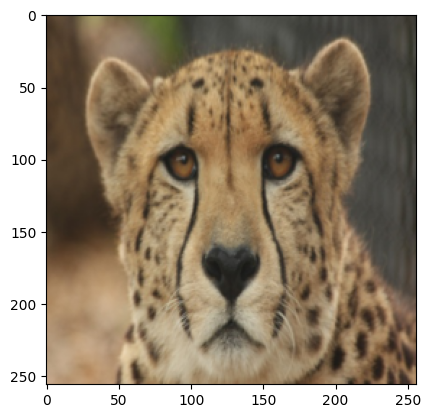

In [ ]:
test_A_real = next(iter(test_data_loader))[0][0] # A
plt.imshow(test_A_real.permute(1,2,0))
plt.show()

In [ ]:
G_A = G_A.to(DEVICE)
G_A.eval()
test_A_fake = G_A(test_A_real.unsqueeze(0).float().to(DEVICE)).squeeze(0).cpu().detach()

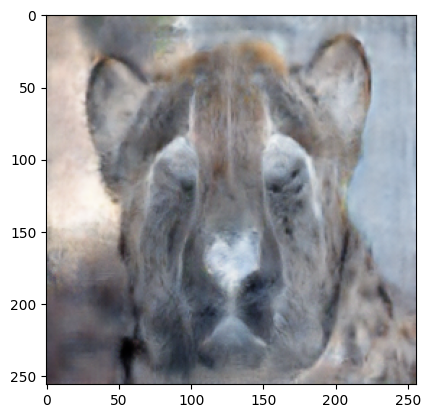

In [ ]:
test_A_fake_post = post_processing_image(test_A_fake)
plt.imshow(test_A_fake_post)
plt.show()

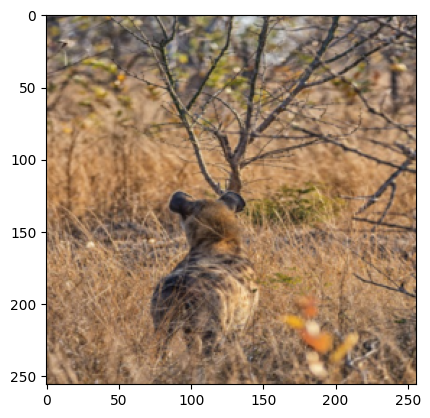

In [ ]:
test_B_real = next(iter(test_data_loader))[1][0] # B
plt.imshow(test_B_real.permute(1,2,0))
plt.show()

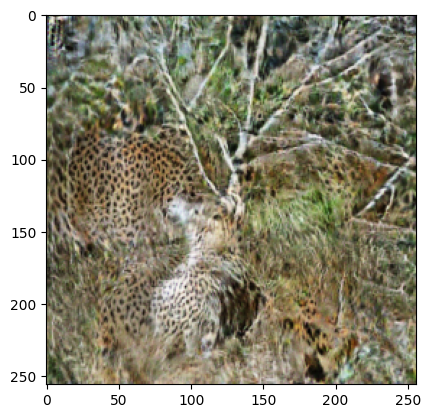

In [ ]:
G_B = G_B.to(DEVICE)
G_B.eval()
test_B_fake = G_B(test_B_real.unsqueeze(0).float().to(DEVICE)).squeeze(0).cpu().detach()

test_B_fake_post = post_processing_image(test_B_fake)
plt.imshow(test_B_fake_post)
plt.show()

In [ ]:
# Generate fake images for multiple test samples
G_A = G_A.to(DEVICE)
G_B = G_B.to(DEVICE)
G_A.eval()
G_B.eval()
output_dir = VISUAL_DIR + "cheetah2hyena/"
for i, (test_A_real, test_B_real) in enumerate(test_data_loader):
  # Test only some samples
  if i == 100:
    break
  
  test_B_fake = G_A(test_A_real.float().to(DEVICE)).squeeze(0).cpu().detach()
  test_A_fake = G_B(test_B_real.float().to(DEVICE)).squeeze(0).cpu().detach()
  save_image(test_A_real, output_dir + "RealA/" + str(i) + ".png")
  save_image(test_B_real, output_dir + "RealB/" + str(i) + ".png")
  Image.fromarray(post_processing_image(test_A_fake)).save(output_dir + "FakeA/" + str(i) + ".png")
  Image.fromarray(post_processing_image(test_B_fake)).save(output_dir + "FakeB/" + str(i) + ".png")

## FID Scores

In [ ]:
!pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


How to use:

`!python -m pytorch_fid <path_to_generated_data> <path_to_real_data>`

In [ ]:
!python -m pytorch_fid "/content/drive/MyDrive/ECE-GY 6953 DL/Project/Visualizations/cheetah2hyena/FakeA" "/content/drive/MyDrive/ECE-GY 6953 DL/Project/Datasets/cheetah2hyena/trainA"

100% 1/1 [00:00<00:00,  1.92it/s]
100% 22/22 [00:06<00:00,  3.30it/s]
FID:  232.5517745186241
